# Dependencies

In [ ]:
import os
import time
import copy
import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Data Collection

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elmehdiamine","key":"3ff3d7b1ae546f99afc1e392d565c06a"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list -s birds

ref                                        title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpiosenka/100-bird-species                 BIRDS 450  SPECIES- IMAGE CLASSIFICATION           2GB  2022-09-30 21:38:09          34535        846  0.85294116       
zhangjuefei/birds-bones-and-living-habits  Birds' Bones and Living Habits                    10KB  2017-01-18 03:53:49           3558         73  0.88235295       
fleanend/birds-songs-numeric-dataset       Birds' Songs Numeric Dataset                      25MB  2019-04-01 09:09:46           1285         30  0.9411765        
rtatman/british-birdsong-dataset           British Birdsong Dataset                         633MB  2017-11-16 21:51:07           2839        121  0.7647059        
usharengaraju/st

In [ ]:
! kaggle datasets download gpiosenka/100-bird-species

100% 1.68G/1.69G [00:13<00:00, 86.1MB/s]
100% 1.69G/1.69G [00:13<00:00, 130MB/s] 


In [ ]:
! unzip /content/100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/VIOLET TURACO/129.jpg  
  inflating: train/VIOLET TURACO/130.jpg  
  inflating: train/VIOLET TURACO/131.jpg  
  inflating: train/VIOLET TURACO/132.jpg  
  inflating: train/VIOLET TURACO/133.jpg  
  inflating: train/VIOLET TURACO/134.jpg  
  inflating: train/VIOLET TURACO/135.jpg  
  inflating: train/VIOLET TURACO/136.jpg  
  inflating: train/VIOLET TURACO/137.jpg  
  inflating: train/VIOLET TURACO/138.jpg  
  inflating: train/VIOLET TURACO/139.jpg  
  inflating: train/VIOLET TURACO/140.jpg  
  inflating: train/VIOLET TURACO/141.jpg  
  inflating: train/VIOLET TURACO/142.jpg  
  inflating: train/VIOLET TURACO/143.jpg  
  inflating: train/VIOLET TURACO/144.jpg  
  inflating: train/VIOLET TURACO/145.jpg  
  inflating: train/VIOLET TURACO/146.jpg  
  inflating: train/VIOLET TURACO/147.jpg  
  inflating: train/VIOLET TURACO/148.jpg  
  inflating: train/VIOLET TURACO/149.jpg  
  inflating: train/VIOLET TURACO/150.jpg  
  i

# Data Augmentation

## Data Directories

In [ ]:
train_dir = "/content/train"
valid_dir = "/content/valid"
test_dir = "/content/test"

## Training Transformations

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

## Inference Transformations

In [ ]:
inference_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(240),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

## Datasets

In [ ]:
def bird_datasets(train_dir=train_dir, valid_dir=valid_dir, test_dir=test_dir):
  train_ds = datasets.ImageFolder(train_dir, transform = train_transform)
  valid_ds = datasets.ImageFolder(valid_dir, transform = inference_transform)
  test_ds = datasets.ImageFolder(test_dir, transform = inference_transform)

  print(f"Training data contains: \t{len(train_ds)} instances")
  print(f"Validation data contains: \t{len(valid_ds)} instances")
  print(f"Testing data contains: \t\t{len(test_ds)} instances")
  
  assert len(train_ds.classes) == len(valid_ds.classes) # making sure the datasets contain the same number of classes
  assert len(valid_ds.classes) == len(test_ds.classes)  
  print(f"\nThere are {len(train_ds.classes)} classes in your datasets")

  return train_ds, valid_ds, test_ds

train_ds, valid_ds, test_ds = bird_datasets()

Training data contains: 	70626 instances
Validation data contains: 	2250 instances
Testing data contains: 		2250 instances

There are 450 classes in your datasets


In [ ]:
class_names = train_ds.classes

## Data Loaders

In [ ]:
def bird_dataloaders(train_ds=train_ds, valid_ds=valid_ds, test_ds=test_ds, bs=64, n_w=2):
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=n_w, pin_memory=True)
  valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=n_w, pin_memory=True)
  test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True, num_workers=n_w, pin_memory=True)

  print("Data is ready to be loaded.")

  return train_dl, valid_dl, test_dl

train_dl, valid_dl, test_dl = bird_dataloaders()

Data is ready to be loaded.


## Visualizing a Sample

Image shape: torch.Size([64, 3, 240, 240])
Class shape: torch.Size([64])


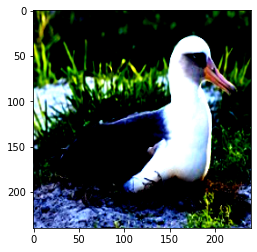

Class number: 8 	 Class name: ALBATROSS


In [ ]:
train_image, train_class = next(iter(train_dl))

print(f"Image shape: {train_image.size()}")
print(f"Class shape: {train_class.size()}")
img = train_image[0].squeeze()
img_class = train_class[0]
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()
print(f"Class number: {img_class} \t Class name: {class_names[img_class]}")

# Different Data Loader Architecture

In [ ]:
data_transforms = {'train': train_transform, 'valid': inference_transform}

image_datasets = {'train': train_ds, 'valid': valid_ds}
dataloaders = {'train': train_dl, 'valid': valid_dl}
dataset_sizes = {'train': len(train_ds), 'valid': len(valid_ds)}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(class_names)

450

# Model Initialization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=8)

Epoch 0/7
----------


100%|██████████| 1104/1104 [04:39<00:00,  3.96it/s]


train Loss: 4.8071 Acc: 0.2053


100%|██████████| 36/36 [00:07<00:00,  4.98it/s]


valid Loss: 3.0922 Acc: 0.5142

Epoch 1/7
----------


100%|██████████| 1104/1104 [04:37<00:00,  3.97it/s]


train Loss: 2.5942 Acc: 0.5953


100%|██████████| 36/36 [00:07<00:00,  4.95it/s]


valid Loss: 1.6767 Acc: 0.7587

Epoch 2/7
----------


100%|██████████| 1104/1104 [04:41<00:00,  3.93it/s]


train Loss: 1.6208 Acc: 0.7439


100%|██████████| 36/36 [00:07<00:00,  4.97it/s]


valid Loss: 1.0798 Acc: 0.8440

Epoch 3/7
----------


100%|██████████| 1104/1104 [04:45<00:00,  3.87it/s]


train Loss: 1.1567 Acc: 0.8089


100%|██████████| 36/36 [00:08<00:00,  4.37it/s]


valid Loss: 0.7798 Acc: 0.8818

Epoch 4/7
----------


100%|██████████| 1104/1104 [04:37<00:00,  3.98it/s]


train Loss: 0.8937 Acc: 0.8465


100%|██████████| 36/36 [00:07<00:00,  4.86it/s]


valid Loss: 0.5911 Acc: 0.8964

Epoch 5/7
----------


100%|██████████| 1104/1104 [04:40<00:00,  3.94it/s]


train Loss: 0.7243 Acc: 0.8709


100%|██████████| 36/36 [00:07<00:00,  4.89it/s]


valid Loss: 0.5031 Acc: 0.9160

Epoch 6/7
----------


100%|██████████| 1104/1104 [04:41<00:00,  3.92it/s]


train Loss: 0.6112 Acc: 0.8898


100%|██████████| 36/36 [00:07<00:00,  4.68it/s]


valid Loss: 0.4222 Acc: 0.9236

Epoch 7/7
----------


100%|██████████| 1104/1104 [04:41<00:00,  3.92it/s]


train Loss: 0.5332 Acc: 0.9070


100%|██████████| 36/36 [00:07<00:00,  4.90it/s]

valid Loss: 0.3934 Acc: 0.9298

Training complete in 38m 25s
Best val Acc: 0.929778


In [ ]:
PATH = '/content/drive/MyDrive/bird_brain_resnet18.pt'
torch.save(model_ft.state_dict(), PATH)

# Alternative

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
## EFFICIENTNET B0
torch.backends.cudnn.benchmark = True
model = models.efficientnet_b1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
n_inputs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(n_inputs,2048),
    nn.SiLU(),
    nn.Dropout(0.2),
    nn.Linear(2048, len(class_names))
)

model = model.to(device)
print(model.classifier)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-533bc792.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=1280, out_features=2048, bias=True)
  (1): SiLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=2048, out_features=450, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.11)
criterion = criterion.to(device)
optimizer = optim.AdamW(model.classifier.parameters(), lr=0.001)

In [ ]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                training_history['accuracy'].append(epoch_acc)
                training_history['loss'].append(epoch_loss)
            elif phase == 'valid':
                validation_history['accuracy'].append(epoch_acc)
                validation_history['loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


100%|██████████| 1122/1122 [04:21<00:00,  4.29it/s]


train Loss: 2.0752 Acc: 0.7653


100%|██████████| 36/36 [00:08<00:00,  4.17it/s]


valid Loss: 1.7018 Acc: 0.8809

Epoch 1/4
----------


100%|██████████| 1122/1122 [04:22<00:00,  4.27it/s]


train Loss: 1.9294 Acc: 0.8058


100%|██████████| 36/36 [00:08<00:00,  4.38it/s]


valid Loss: 1.7141 Acc: 0.8791

Epoch 2/4
----------


100%|██████████| 1122/1122 [04:21<00:00,  4.28it/s]


train Loss: 1.6794 Acc: 0.8872


100%|██████████| 36/36 [00:08<00:00,  4.29it/s]


valid Loss: 1.5844 Acc: 0.9160

Epoch 3/4
----------


100%|██████████| 1122/1122 [04:21<00:00,  4.29it/s]


train Loss: 1.5945 Acc: 0.9107


100%|██████████| 36/36 [00:08<00:00,  4.42it/s]


valid Loss: 1.5393 Acc: 0.9133

Epoch 4/4
----------


100%|██████████| 1122/1122 [04:21<00:00,  4.29it/s]


train Loss: 1.5507 Acc: 0.9235


100%|██████████| 36/36 [00:08<00:00,  4.34it/s]


valid Loss: 1.5501 Acc: 0.9120

Training complete in 22m 31s
Best val Acc: 0.916000


In [ ]:
PATH = '/content/drive/MyDrive/bird_brain.pt'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
PATH = '/content/drive/MyDrive/bird_brain_resnet18.pt'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(class_names)))
  class_total = list(0. for i in range(len(class_names)))

  model.eval()

  for data, target in tqdm.tqdm(test_dl):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_dl.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(class_names)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              class_names[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))

In [ ]:
test(model_ft)

100%|██████████| 36/36 [00:09<00:00,  3.92it/s]


Test Loss: 0.356323

Test Accuracy of ABBOTTS BABBLER: 100% ( 5/ 5)
Test Accuracy of ABBOTTS BOOBY: 40% ( 2/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 100% ( 5/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 80% ( 4/ 5)
Test Accuracy of AFRICAN FIREFINCH: 100% ( 5/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of AFRICAN PIED HORNBILL: 60% ( 3/ 5)
Test Accuracy of ALBATROSS: 100% ( 5/ 5)
Test Accuracy of ALBERTS TOWHEE: 80% ( 4/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 100% ( 5/ 5)
Test Accuracy of ALPINE CHOUGH: 100% ( 5/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 60% ( 3/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 4/ 4)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN FLAMINGO: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 100% ( 5/ 5)
Test Accuracy of AMERICAN KESTREL: 100% ( 5/ 5)
Test Accuracy of AMERICAN PIPIT: 100% ( 5/ 5)
T

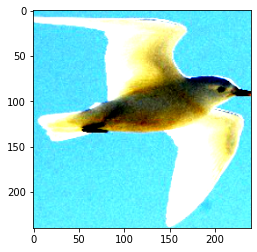

The correct class name: IVORY GULL
The answer of the model: 277, IVORY GULL


In [ ]:
test_image, test_class = next(iter(test_dl))
img = test_image[0].squeeze()
img_class = test_class[0]
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()
print(f"The correct class name: {class_names[img_class]}")
model_ft.eval()
output = model_ft(test_image.cuda())
_, pred = torch.max(output, 1)  
print(f"The answer of the model: {pred[0]}, {class_names[pred[0]]}")

## Best Model ResNet 34

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, foreach=None, maximize=False, capturable=False)
#optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
PATH = '/content/drive/MyDrive/bird_brain_resnet34_Adam.pt'
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
def test(model):
  test_loss = 0.0
  class_correct = list(0. for i in range(len(class_names)))
  class_total = list(0. for i in range(len(class_names)))
  all_labels = torch.tensor([]).cuda()
  all_preds = torch.tensor([]).cuda()

  model.eval()

  for data, target in tqdm.tqdm(test_dl):
      if torch.cuda.is_available(): 
          data, target = data.cuda(), target.cuda()
      with torch.no_grad():
        output = model(data)
        loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1) 
      all_labels = torch.cat((all_labels, target))
      all_preds = torch.cat((all_preds, pred))
      # print("--------------")
      # print("Label: ", target)
      # print("Prediction: ", pred) 
      # print("--------------")  
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

  test_loss = test_loss/len(test_dl.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(len(class_names)):
      if class_total[i] > 0:
          print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              class_names[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (class_names[i]))

  print('\nTest Accuracy (Overall): {:.4f} ({}/{})'.format(
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  return class_correct, class_total, all_labels, all_preds

In [ ]:
class_correct, class_total, all_labels, all_preds = test(model_ft)

100%|██████████| 36/36 [00:14<00:00,  2.49it/s]


Test Loss: 0.096621

Test Accuracy of ABBOTTS BABBLER: 100% ( 5/ 5)
Test Accuracy of ABBOTTS BOOBY: 80% ( 4/ 5)
Test Accuracy of ABYSSINIAN GROUND HORNBILL: 100% ( 5/ 5)
Test Accuracy of AFRICAN CROWNED CRANE: 100% ( 5/ 5)
Test Accuracy of AFRICAN EMERALD CUCKOO: 100% ( 5/ 5)
Test Accuracy of AFRICAN FIREFINCH: 100% ( 5/ 5)
Test Accuracy of AFRICAN OYSTER CATCHER: 100% ( 5/ 5)
Test Accuracy of AFRICAN PIED HORNBILL: 100% ( 5/ 5)
Test Accuracy of ALBATROSS: 100% ( 5/ 5)
Test Accuracy of ALBERTS TOWHEE: 100% ( 5/ 5)
Test Accuracy of ALEXANDRINE PARAKEET: 100% ( 5/ 5)
Test Accuracy of ALPINE CHOUGH: 100% ( 5/ 5)
Test Accuracy of ALTAMIRA YELLOWTHROAT: 100% ( 5/ 5)
Test Accuracy of AMERICAN AVOCET: 100% ( 5/ 5)
Test Accuracy of AMERICAN BITTERN: 100% ( 5/ 5)
Test Accuracy of AMERICAN COOT: 100% ( 5/ 5)
Test Accuracy of AMERICAN FLAMINGO: 100% ( 5/ 5)
Test Accuracy of AMERICAN GOLDFINCH: 100% ( 5/ 5)
Test Accuracy of AMERICAN KESTREL: 100% ( 5/ 5)
Test Accuracy of AMERICAN PIPIT: 100% ( 5/ 

In [ ]:
all_labels[:4], all_preds[:4]

(tensor([ 72., 329., 199., 179.], device='cuda:0'),
 tensor([ 72., 329., 199., 179.], device='cuda:0'))

In [ ]:
cf_matrix = confusion_matrix(all_labels.cpu().numpy(), all_preds.cpu().numpy())

In [ ]:
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

In [ ]:
dataframe

,ABBOTTS BABBLER,ABBOTTS BOOBY,ABYSSINIAN GROUND HORNBILL,AFRICAN CROWNED CRANE,AFRICAN EMERALD CUCKOO,AFRICAN FIREFINCH,AFRICAN OYSTER CATCHER,AFRICAN PIED HORNBILL,ALBATROSS,ALBERTS TOWHEE,...,WHITE CRESTED HORNBILL,WHITE NECKED RAVEN,WHITE TAILED TROPIC,WHITE THROATED BEE EATER,WILD TURKEY,WILSONS BIRD OF PARADISE,WOOD DUCK,YELLOW BELLIED FLOWERPECKER,YELLOW CACIQUE,YELLOW HEADED BLACKBIRD
ABBOTTS BABBLER,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABBOTTS BOOBY,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABYSSINIAN GROUND HORNBILL,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFRICAN CROWNED CRANE,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AFRICAN EMERALD CUCKOO,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WILSONS BIRD OF PARADISE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
WOOD DUCK,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,0,0,0
YELLOW BELLIED FLOWERPECKER,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,0,0
YELLOW CACIQUE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,0


In [ ]:
dataframe.to_csv('confusionmatrix.csv')

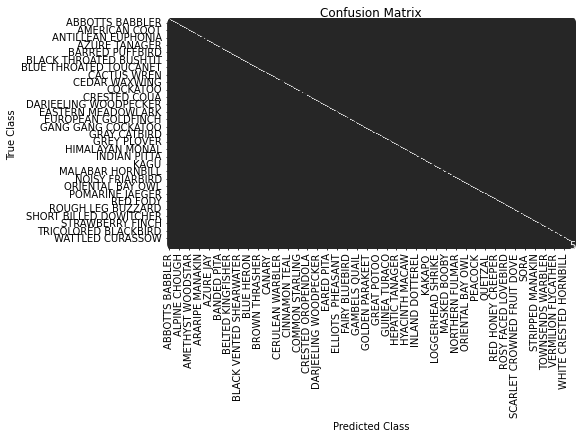

In [ ]:
plt.figure(figsize=(8, 6))

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

# Interpretation

In [ ]:
np.argmin(class_correct)

391

In [ ]:
class_total[72]

4.0

In [ ]:
class_names[72]

'BLACK SKIMMER'

In [ ]:
al = np.array([5, 3, 2, 8, 0, 1])
ind = np.argpartition(al, 3)[:3]
al[ind]

array([0, 1, 2])

In [ ]:
np_class_correct = np.array(class_correct)
ind = np.argpartition(np_class_correct, 3)[:3]
np_class_correct[ind]

array([0., 2., 3.])

In [ ]:
ind

array([391, 297, 420])

In [ ]:
np_class_total = np.array(class_total)
np_class_total[ind]

array([5., 5., 5.])

In [ ]:
np_class_names = np.array(class_names)
np_class_names[ind]

array(['SKUA', 'LOGGERHEAD SHRIKE', 'TRICOLORED BLACKBIRD'], dtype='<U29')

## The 3 worse performing classes

In [ ]:
print(f"The 3 worse performing classes are: {ind}")
print(f"There names are: {np_class_names[ind]}")

The 8 worse performing classes are: [391 297 420]
There names are: ['SKUA' 'LOGGERHEAD SHRIKE' 'TRICOLORED BLACKBIRD']


In [ ]:
for idx in ind:
  print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
              np_class_names[idx], 100 * np_class_correct[idx] / np_class_total[idx],
              np.sum(np_class_correct[idx]), np.sum(np_class_total[idx])))

Test Accuracy of  SKUA:  0% ( 0/ 5)
Test Accuracy of LOGGERHEAD SHRIKE: 40% ( 2/ 5)
Test Accuracy of TRICOLORED BLACKBIRD: 60% ( 3/ 5)
